In [43]:
from typing import TypedDict, List, Literal
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_nvidia_ai_endpoints import ChatNVIDIA

loader = PyMuPDFLoader("D:\Code\GIt repo\internship+gen ai\quadrag\Hands-on-ML-ml.pdf")
docs = loader.load()

#  Split 
splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
chunks = splitter.split_documents(docs)

#  vectors
vectorstore = Chroma(
    collection_name="hands-on-ml",
    embedding_function=NVIDIAEmbeddings(),
    persist_directory="hands-on-ml1"
)
# vectorstore.add_documents(chunks)  # if not already added so not needed if already added
retriever = vectorstore.as_retriever()

#  LLM
llm = ChatNVIDIA(model="mixtral_8x7b")

# Define the state
class AgentState(TypedDict):
    question: str
    documents: List[str]
    generation: str
    should_rewrite: bool
    is_hallucination: bool
    answer_meets_question: bool

# Define your prompt template
prompt = PromptTemplate(
    template="""
    You are Professional Book Reader and you are reading a book called "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.
    As a reader user I will ask you questions about the book and you will answer them based on the context of the book.
    Here is the context of the book: {context}
    
    Also here is some advice for you:
    1. Always answer the question based on the context of the book.
    2. If the question is not related to the book, say "I don't know".
    3. If the question is not clear, ask for clarification.
    4. You are a professional book reader, so you should answer the question in a professional way also if user needs explanation then explain like a Great Professor of prestigious University explain with Real-world example(s).
    5. If the question is about a specific chapter, mention the chapter number and title in your answer.
    6. If need some Mathematical formula to answer the question then use LaTeX format to write the formula.
    
    Here is the question: {question}
    Answer the question based on the context of the book.
    """,
    input_variables=["context", "question"],
)



d:\ana\envs\langchain_env\lib\site-packages\langchain_nvidia_ai_endpoints\_statics.py:810: UserWarning: Model mixtral_8x7b is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(


In [44]:

# Rewrite prompt
rewrite_prompt = PromptTemplate(
    template="Rewrite this question to be more specific for retrieval from the book:\n\n{question}",
    input_variables=["question"]
)

# Hallucination check prompt (optional upgrade)
hallucination_check_prompt = PromptTemplate(
    template="""
You are a hallucination detector. Given the following context and answer,
determine whether the answer is fully supported by the context.

Context:
{context}

Answer:
{generation}

If yes, say: "No Hallucination". If not, say: "Hallucination Detected".
""",
    input_variables=["context", "generation"]
)


In [45]:
# main QA chain
qa_chain = prompt | llm | StrOutputParser()

# rewrite chain
rewrite_chain = rewrite_prompt | llm | StrOutputParser()

# hallucination 
hallucination_chain = hallucination_check_prompt | llm | StrOutputParser()

In [46]:
# node functions 
def retrieve_docs(state: AgentState) -> AgentState:
    print("🔍 Retrieving documents...")
    docs = retriever.invoke(state["question"])
    return {**state, "documents": docs}

def grade_docs(state: AgentState) -> AgentState:
    print("📊 Grading documents...")
    if not state["documents"]:
        return {**state, "should_rewrite": True}
    return {**state, "should_rewrite": False}

def generate_answer(state: AgentState) -> AgentState:
    print("🧠 Generating answer...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    generation = qa_chain.invoke({"context": context, "question": state["question"]})
    return {**state, "generation": generation}

def check_hallucination(state: AgentState) -> AgentState:
    print("👁️ Checking for hallucinations...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    result = hallucination_chain.invoke({
        "context": context,
        "generation": state["generation"]
    })
    return {**state, "is_hallucination": "Hallucination Detected" in result}

def check_answers_question(state: AgentState) -> AgentState:
    print("✅ Checking if answer meets question...")
    if state["generation"] and "I don't know" not in state["generation"]:
        return {**state, "answer_meets_question": True}
    return {**state, "answer_meets_question": False}

def rewrite_question(state: AgentState) -> AgentState:
    print("🔄 Rewriting question...")
    new_question = rewrite_chain.invoke({"question": state["question"]})
    return {**state, "question": new_question, "should_rewrite": False}

#decison functions
def grade_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if not state["should_rewrite"] else "no"

def hallucination_condition(state: AgentState) -> Literal["yes", "no"]:
    return "no" if not state["is_hallucination"] else "yes"

def check_answer_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if state["answer_meets_question"] else "no"


In [54]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# Add core nodes
workflow.add_node("retrieve", retrieve_docs)
workflow.add_node("grade", grade_docs)
workflow.add_node("generate", generate_answer)
workflow.add_node("hallucination", check_hallucination)
workflow.add_node("check_answer", check_answers_question)
workflow.add_node("rewrite", rewrite_question)

# Add conditional edges
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges("grade", grade_condition, {"yes": "generate", "no": "rewrite"})
workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("generate", "hallucination")
workflow.add_conditional_edges("hallucination", hallucination_condition, {"yes": "generate", "no": "check_answer"})
workflow.add_conditional_edges("check_answer", check_answer_condition, {"yes": END, "no": "rewrite"})

app= workflow.compile()

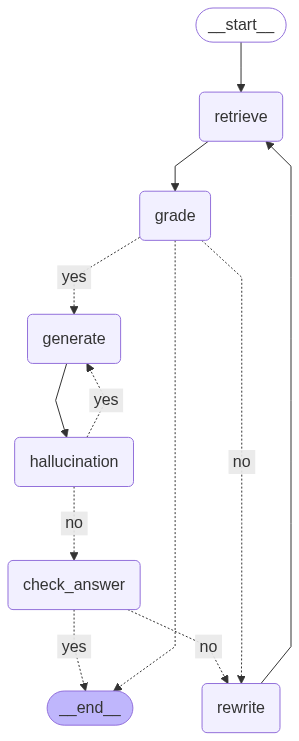

In [55]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [56]:

input_state = {"question": "What is the difference between batch and stochastic gradient descent?"}

final_state = app.invoke(input_state)
print("\n📝 Final Answer:\n", final_state["generation"])


🔍 Retrieving documents...
📊 Grading documents...
🧠 Generating answer...
👁️ Checking for hallucinations...
✅ Checking if answer meets question...

📝 Final Answer:
 The main difference between Batch Gradient Descent and Stochastic Gradient Descent lies in the way they update the parameters during the training of a model.

Batch Gradient Descent uses the entire training set to compute the gradients at every step, which makes it very slow when dealing with large datasets. In contrast, Stochastic Gradient Descent uses a single training example at a time to compute the gradients, which makes each training step much faster. However, this also makes Stochastic Gradient Descent more stochastic, which can help the algorithm jump out of local minima and potentially find the global minimum in cases where the cost function is very irregular.

In other words, Batch Gradient Descent provides a stable and precise path toward the minimum of the cost function, while Stochastic Gradient Descent provides 

In [57]:

input_state = {"question": "What is machine learning? its types" }

final_state = app.invoke(input_state)
print("\n📝 Final Answer:\n", final_state["generation"])


🔍 Retrieving documents...
📊 Grading documents...
🧠 Generating answer...
👁️ Checking for hallucinations...
✅ Checking if answer meets question...

📝 Final Answer:
 Machine learning is a subset of artificial intelligence that enables systems to learn and improve from experience without being explicitly programmed. The book "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron classifies machine learning systems into four major categories based on the amount and type of supervision they receive during training:

1. **Supervised Learning**: In supervised learning, the model is trained using labeled data, where each example includes both input data and the corresponding output or target variable. The model learns to map inputs to outputs based on these examples and can then make predictions on new, unseen data. Examples of supervised learning tasks include classification, regression, and prediction problems.

2. **Unsupervised Learning**: In unsupervised lea

In [58]:

input_state = {"question": "how random forest and ensemble models are diffrents is both are same or not same one line answer" }

final_state = app.invoke(input_state)
print("\n📝 Final Answer:\n", final_state["generation"])


🔍 Retrieving documents...
📊 Grading documents...
🧠 Generating answer...
👁️ Checking for hallucinations...
✅ Checking if answer meets question...

📝 Final Answer:
 While both Random Forest and Ensemble models are related, they are not exactly the same thing. An Ensemble model is a general term that refers to any Machine Learning model that combines the predictions of multiple other models, with the goal of improving accuracy. On the other hand, a Random Forest is a specific type of Ensemble model that is built using an ensemble of Decision Trees, where each tree is trained on a different random subset of the training data. So, while a Random Forest is a type of Ensemble model, not all Ensemble models are Random Forests. (Chapter 7: Ensemble Learning and Random Forests)
